<a href="https://colab.research.google.com/github/DeeeTeeee/TensorFlowDeveloperCert/blob/main/Using_CNN's_with_the_Cats_vs_Dogs_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN's with the Cats vs Dogs Dataset

## By David Anifowoshe

I will be using the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. For this, I will create my own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.



Let's get started!

In [1]:
# import libs

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Downloading the dataset from its original source by running the cell below.

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-11-21 15:49:21--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.199.2.10, 2600:1406:4c00:2aa::317f, 2600:1406:4c00:296::317f, ...
Connecting to download.microsoft.com (download.microsoft.com)|23.199.2.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   197MB/s    in 3.9s    

2023-11-21 15:49:25 (200 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


I need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, lets `create_train_val_dirs` below:

In [4]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# create_train_val_dirs
def create_train_val_dirs(root_path):


  train_dir = os.path.join(root_path, 'training')
  validation_dir = os.path.join(root_dir, 'validation')

  # Directory with training cat/dog pictures
  train_cats_dir = os.path.join(train_dir, 'cats')
  train_dogs_dir = os.path.join(train_dir, 'dogs')

  # Directory with validation cat/dog pictures
  validation_cats_dir = os.path.join(validation_dir, 'cats')
  validation_dogs_dir = os.path.join(validation_dir, 'dogs')

  # Create directories
  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)
  os.makedirs(validation_cats_dir)
  os.makedirs(validation_dogs_dir)


  pass




try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
# Test the create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


Coding the `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)
- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)
- SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then the function should print out a message such as `"filename is zero length, so ignoring."`.

In [6]:

# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

     # Get the list of files in the source directory
  files = os.listdir(SOURCE_DIR)

    # Shuffle the list of files
  random.shuffle(files)

    # Calculate the split index based on SPLIT_SIZE
  split_index = int(len(files) * SPLIT_SIZE)

    # Split the files into training and validation sets
  train_files = files[:split_index]
  val_files = files[split_index:]

    # Copy files to training directory
  for file in train_files:
        source_path = os.path.join(SOURCE_DIR, file)
        destination_path = os.path.join(TRAINING_DIR, file)

        # Check if the file is not empty before copying
        if os.path.getsize(source_path) > 0:
            copyfile(source_path, destination_path)
        else:
            print(f"{file} is zero length, so ignoring.")

    # Copy files to validation directory
  for file in val_files:
        source_path = os.path.join(SOURCE_DIR, file)
        destination_path = os.path.join(VALIDATION_DIR, file)

        # Check if the file is not empty before copying
        if os.path.getsize(source_path) > 0:
            copyfile(source_path, destination_path)
        else:
            print(f"{file} is zero length, so ignoring.")


        pass


In [7]:

# Test split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1249 images of dogs for validation


Now that we have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows us to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise, use a `target_size` of (150, 150)**.

In [8]:

# train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """



  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [9]:
# Test  generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


One last step before training is to define the architecture of the model that will be trained.

Completing the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` I can tell if they aren't compatible if you get an error during training.

In [10]:


# create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USING AT LEAST 3 CONVOLUTION LAYERS


  model = tf.keras.models.Sequential([
        # First Convolutional Layer
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Second Convolutional Layer
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Third Convolutional Layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a Dense Layer
        tf.keras.layers.Flatten(),
        # Dense Layer
        tf.keras.layers.Dense(512, activation='relu'),
        # Output Layer
        tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  from tensorflow.keras.optimizers import RMSprop
  model.compile(optimizer= RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])



  return model

Now it is time to train my model!

In [11]:
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 76/704 [==>...........................] - ETA: 52s - loss: 0.7252 - accuracy: 0.5103

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


704/704 [==============================] - 62s 75ms/step - loss: 0.6064 - accuracy: 0.6614 - val_loss: 0.5100 - val_accuracy: 0.7367
Epoch 2/15
704/704 [==============================] - 50s 70ms/step - loss: 0.4736 - accuracy: 0.7740 - val_loss: 0.4602 - val_accuracy: 0.7827
Epoch 3/15
704/704 [==============================] - 51s 73ms/step - loss: 0.3931 - accuracy: 0.8228 - val_loss: 0.3928 - val_accuracy: 0.8179
Epoch 4/15
704/704 [==============================] - 50s 71ms/step - loss: 0.3216 - accuracy: 0.8590 - val_loss: 0.4426 - val_accuracy: 0.8087
Epoch 5/15
704/704 [==============================] - 52s 74ms/step - loss: 0.2395 - accuracy: 0.8993 - val_loss: 0.4472 - val_accuracy: 0.8439
Epoch 6/15
704/704 [==============================] - 49s 70ms/step - loss: 0.1507 - accuracy: 0.9422 - val_loss: 0.6131 - val_accuracy: 0.8059
Epoch 7/15
704/704 [==============================] - 51s 73ms/step - loss: 0.0816 - accuracy: 0.9703 - val_loss: 0.7215 - val_accuracy: 0.8271
Epo


## **My model achieved a training accuracy of at least 99% and a validation accuracy of at least 85%**.

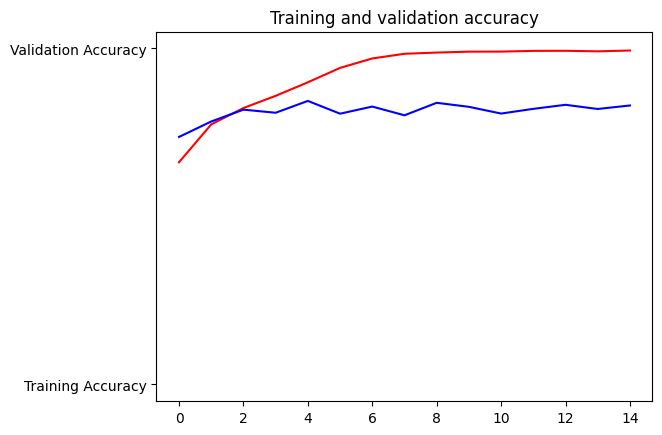

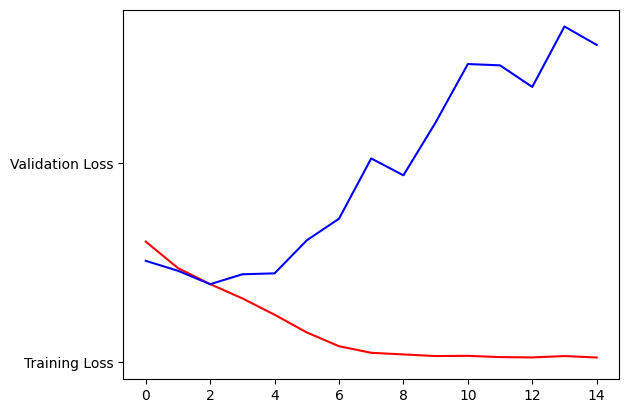

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Geting number of epochs

#------------------------------------------------
# Ploting training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and I will will mitigate this issue later.

Before downloading this notebook let pickle the model and download the `history.pkl` file which contains the information of the training history of our model.

In [14]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Downloading notebook

In [15]:
# Download metadata checker
!wget -nc https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py

--2023-11-21 16:10:10--  https://storage.googleapis.com/tensorflow-1-public/colab_metadata_checker.py
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997 (2.0K) [text/x-python-script]
Saving to: ‘colab_metadata_checker.py’

colab_metadata_chec 100%[===================>]   1.95K  --.-KB/s    in 0s      

2023-11-21 16:10:10 (49.9 MB/s) - ‘colab_metadata_checker.py’ saved [1997/1997]



In [16]:
import colab_metadata_checker

# Please see the output of this cell to see which file you need to submit to the grader
colab_metadata_checker.run("Using CNN's with the Cats vs Dogs Dataset.ipynb")

Grader metadata detected! You can download this notebook by clicking `File > Download > Download as .ipynb` and submit it to the grader!
